# Import Library/Module

In [1]:
import pickle
import shutil
import os
import pandas as pd
from tempfile import TemporaryDirectory
from numpy.testing import (assert_equal, assert_almost_equal,
                           assert_raises, assert_allclose)

Notes:
* Generating stats has contracdicting instructions: trips key in instructions, trip in asserts
* Plots drivers descending in df but looks ascending in plot

# Class SakayDB

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


class SakayDBError(ValueError):

    def __init__(self, text=None):
        super().__init__(text)


class SakayDB():

    def __init__(self, data_dir):
        self.data_dir = data_dir

    def add_trip(self, driver, pickup_datetime, dropoff_datetime,
                 passenger_count, pickup_loc_name, dropoff_loc_name,
                 trip_distance, fare_amount):
        '''
        Match `driver` to the existing `last_name`, `given_name`
        (case-insensitive) in `drivers.csv` and extract the corresponding
        `driver_id`. If `driver` is new, append `driver` to `drivers.csv`
        and assign last `driver_id` + 1 as `driver_id` or `1` if there is no
        `drivers.csv`. Match the location (pickup/dropoff) to the existing
        `loc_name` (case-insensitive) in `locations.csv` and extract the
        corresponding `location_id`. If the location is new, append the
        location to `locations.csv` and assign last `location_id` + 1 as
        `location_id` or `1` if there is no `locations.csv`. Add the trip data
        to the existing `trips.csv` or create `trips.csv` if it does not
        exist.

        Parameters
        ----------
        driver : str
            The name of the driver in the format of LAST NAME, GIVEN NAME.
        pickup_datetime : str
            The exact date and time of pick up in the format of
            "hh:mm:ss,DD-MM-YYYY".
        dropoff_datetime : str
            The exact date and time of drop off in the format of
            "hh:mm:ss,DD-MM-YYYY".
        passenger_count : int
            The number of passengers in the trip.
        pickup_loc_name : str
            The zone/location where the passenger was picked up.
        dropoff_loc_name : str
            The zone/location where the passenger was dropped off.
        trip_distance : float
            The distance of the trip in meters.
        fare_amount : float
            The amount due for the trip as paid by the passenger.

        Returns
        -------
        trip_id : int
            The `trip_id` of the successful trip entry in `trips.csv`.

        Raises
        ------
        SakayDBError
            If any of the Parameters is invalid.
            If trip is already in `trips.csv`.
        '''

        # Detecting if the inputs are valid otherwise raise an error
        try:
            driver_name = driver.strip().split(', ')
            if len(driver_name) != 2:
                raise SakayDBError('has invalid or incomplete information')
            pickup_datetime = pickup_datetime.strip()
            pickup_date = pd.to_datetime(pickup_datetime.strip(),
                                         format='%H:%M:%S,%d-%m-%Y')
            dropoff_datetime = dropoff_datetime.strip()
            dropoff_date = pd.to_datetime(dropoff_datetime.strip(),
                                         format='%H:%M:%S,%d-%m-%Y')
            pickup_loc_name = pickup_loc_name.strip()
            dropoff_loc_name = dropoff_loc_name.strip()
            passenger_count = int(passenger_count)
            trip_distance = float(trip_distance)
            fare_amount = float(fare_amount)
        except:
            raise SakayDBError('has invalid or incomplete information')

        # Creating the directory path
        trip_dir = os.path.join(self.data_dir, 'trips.csv')
        driver_dir = os.path.join(self.data_dir, 'drivers.csv')
        loc_dir = os.path.join(self.data_dir, 'locations.csv')

        # Checks if the driver exists in database otherwise create new entry
        if os.path.exists(driver_dir):
            df_drivers = pd.read_csv(driver_dir)
            df_tripdriver = df_drivers[(df_drivers['last_name'].str.lower()
                                       == driver_name[0].lower())
                                       & (df_drivers['given_name'].str.lower()
                                       == driver_name[1].lower())]
            if df_tripdriver.shape[0] == 0:
                driver_id = df_drivers.loc[df_drivers.shape[0] - 1,
                                           'driver_id'] + 1
                df_drivers.loc[len(df_drivers)] = [driver_id,
                                                   driver_name[1].title(),
                                                   driver_name[0].title()]
            else:
                driver_id = df_tripdriver.iloc[0, 0]
        else:
            df_drivers = pd.DataFrame(columns=['driver_id',
                                               'given_name', 'last_name'])
            driver_id = 1
            df_drivers.loc[len(df_drivers)] = [driver_id,
                                               driver_name[1].title(),
                                               driver_name[0].title()]

        # Checks if the pickpup exists in database otherwise create new entry
        if os.path.exists(loc_dir):
            df_locs = pd.read_csv(loc_dir)
            df_pickup = df_locs[df_locs['loc_name'].str.lower()
                                == pickup_loc_name.lower()]
            if df_pickup.shape[0] == 0:
                pickup_id = df_locs.loc[df_locs.shape[0] - 1,
                                        'location_id'] + 1
                df_locs.loc[len(df_locs)] = [pickup_id,
                                             pickup_loc_name.title()]
            else:
                pickup_id = df_pickup.iloc[0, 0]
        else:
            df_locs = pd.DataFrame(columns=['location_id', 'loc_name'])
            pickup_id = 1
            df_locs.loc[len(df_locs)] = [pickup_id, pickup_loc_name.title()]
            
        # Checks if the dropoff exists in database otherwise create new entry
        if os.path.exists(loc_dir):
            df_locs = pd.read_csv(loc_dir)
            df_dropoff = df_locs[df_locs['loc_name'].str.lower()
                                 == dropoff_loc_name.lower()]
            if df_dropoff.shape[0] == 0:
                dropoff_id = df_locs.loc[df_locs.shape[0] - 1,
                                         'location_id'] + 1
                df_locs.loc[len(df_locs)] = [dropoff_id,
                                             dropoff_loc_name.title()]
            else:
                dropoff_id = df_dropoff.iloc[0, 0]
        else:
            df_locs = pd.DataFrame(columns=['location_id', 'loc_name'])
            dropoff_id = 1
            df_locs.loc[len(df_locs)] = [dropoff_id, dropoff_loc_name.title()]
            

        # Checks if the trip exists in database otherwise create new entry
        if os.path.exists(trip_dir):
            df_trips = pd.read_csv(trip_dir)
            df_trip = df_trips[(df_trips['driver_id'] == driver_id)
                               & (df_trips['pickup_datetime']
                                  == pickup_datetime)
                               & (df_trips['dropoff_datetime']
                                  == dropoff_datetime)
                               & (df_trips['passenger_count']
                                  == passenger_count)
                               & (df_trips['pickup_loc_id'] == pickup_id)
                               & (df_trips['dropoff_loc_id'] == dropoff_id)
                               & (np.isclose(df_trips['trip_distance'],
                                             trip_distance))
                               & (np.isclose(df_trips['fare_amount'],
                                             fare_amount))]
            if df_trip.shape[0] == 0:
                trip_id = df_trips.loc[df_trips.shape[0] - 1, 'trip_id'] + 1
                df_trips.loc[len(df_trips)] = [trip_id, driver_id,
                                               pickup_datetime,
                                               dropoff_datetime,
                                               passenger_count,
                                               pickup_id, dropoff_id,
                                               trip_distance, fare_amount]
            else:
                raise SakayDBError('is already in the database')
        else:
            df_trips = pd.DataFrame(columns=['trip_id', 'driver_id',
                                             'pickup_datetime',
                                             'dropoff_datetime',
                                             'passenger_count',
                                             'pickup_loc_id',
                                             'dropoff_loc_id',
                                             'trip_distance', 'fare_amount'])
            trip_id = 1
            df_trips.loc[len(df_trips)] = [trip_id, driver_id,
                                           pickup_datetime,
                                           dropoff_datetime, passenger_count,
                                           pickup_id, dropoff_id,
                                           trip_distance, fare_amount]

        # Updates csv files and returns trip_id
        df_drivers.to_csv(driver_dir, index=False)
        df_locs.to_csv(loc_dir, index=False)
        df_trips.to_csv(trip_dir, index=False)
        return trip_id

    def add_trips(self, trips):
        '''
        Accepts a list of trips in dictionary format
        
        Parameters:
        trips: List that contain dictionaries with the following keys:
        driver (str): The name of the driver in the format of 
            LAST NAME, GIVEN NAME
        pickup_datetime (str): The exact date and time of pick up in the 
            format of “hh:mm:ss,DD-MM-YY”
        dropoff_datetime (str): The exact date and time of drop off in the 
            format of “hh:mm:ss,DD-MM-YY”
        passenger_count (int): The number of passengers in the trip
        pickup_loc_name (str): The zone/location where the passenger was 
            picked up e.g. (Pine View, Legazpi Village)
        dropoff_loc_name (str): The zone/location where the passenger was 
            dropped off e.g. (Pine View, Legazpi Village)
        trip_distance (float): The distance of the trip in meters
        fare_amount (float): The amount due for the trip as paid by the 
            passenger
        
        Returns: 
        trip_ids which:
            Is a list of trip_ids that are successfully appended 
                to trips.csv
        
        Raises:
        Warning when:
            A trip in trip_ids is already existing in trips.csv
            A trip in trip_ids has invalid or incomplete information
        
        Note that trip_ids that raised a warning will be skipped
        '''
        trip_ids = []
        for i, trip in enumerate(trips):
            try:
                trip_id = self.add_trip(trip['driver'],
                                        trip['pickup_datetime'],
                                        trip['dropoff_datetime'],
                                        trip['passenger_count'],
                                        trip['pickup_loc_name'],
                                        trip['dropoff_loc_name'],
                                        trip['trip_distance'],
                                        trip['fare_amount'])
                trip_ids.append(trip_id)
            except SakayDBError as error_text:
                print(f'Warning: trip index {i} {error_text}. Skipping...')
            except:
                print(f'Warning: trip index {i}'
                      ' has invalid or incomplete information. Skipping...')
        return trip_ids

    def delete_trip(self, trip_id):
        '''
        Accepts a trip_id and deletes it from trips.csv
        
        Parameter:
        trip_id (int): Number assigned to a trip
        
        Returns: 
        An updated data frame that no longer includes trip_id
        
        Raises: 
        SakayDBError when:
            The trip_id does not exist in trips.csv
            Trips.csv is empty
        '''
        trip_dir = os.path.join(self.data_dir, 'trips.csv')

        # Checks if the file exists otherwise raise an error
        if os.path.exists(trip_dir):
            df_trips = pd.read_csv(trip_dir)
            df_trip = df_trips[df_trips['trip_id'] == trip_id]

            if df_trip.shape[0] == 0:
                raise SakayDBError
            else:
                df_trips = df_trips[df_trips['trip_id'] != trip_id]
                df_trips.to_csv(trip_dir, index=False)
                return trip_id
        else:
            raise SakayDBError
            
    def search_trips(self, **kwargs):
        '''
        Fetches and returns input that can either be:
        Exact: Single value keyword that should be in any of the keys below
        Range: A tuple that includes two keywords from any of the keys below 
        
        Keyword arguments: 
            **kwargs (str): Keys from the ff: driver_id, pickup_datetime, 
            dropoff_datetime, passenger_count, trip_distance, fare_amount
        
        Raises: 
        SakayDBError when:
                Keyword is not a key from any of the above
                Range input with more than two keywords
        '''
        valid_keys = ['driver_id', 'pickup_datetime', 'dropoff_datetime',
                      'passenger_count', 'trip_distance', 'fare_amount']
        date_keys = ['pickup_datetime', 'dropoff_datetime']
        float_keys = ['driver_id', 'passenger_count',
                      'trip_distance', 'fare_amount']

        # Checks if valid keyword argument
        keys = kwargs.keys()
        chk = any([True if key not in valid_keys else False for key in keys])
        if len(keys) == 0 or chk:
            raise SakayDBError

        # Checks if the database exists otherwise returns empty list
        trip_dir = os.path.join(self.data_dir, 'trips.csv')
        if os.path.exists(trip_dir):
            df_trips = pd.read_csv(trip_dir)
        else:
            return []

        # Keep a copy of string format datetime
        # Cast the other copy to a datetime format
        df_trips.insert(loc=4, column='pickup_string',
                        value=df_trips['pickup_datetime'])
        df_trips.insert(loc=5, column='dropoff_string',
                        value=df_trips['dropoff_datetime'])
        df_trips['pickup_datetime'] = \
            pd.to_datetime(df_trips['pickup_datetime'],
                           format='%H:%M:%S,%d-%m-%Y')
        df_trips['dropoff_datetime'] = \
            pd.to_datetime(df_trips['dropoff_datetime'],
                           format='%H:%M:%S,%d-%m-%Y')

        # For valid keys
        for key, value in kwargs.items():
            try:
                if type(value) is tuple:
                    if len(value) != 2:
                        raise SakayDBError

                    # Change value format to be aligned with valid format
                    value = list(value)
                    if key in float_keys:
                        if value[0] is not None:
                            value[0] = float(value[0])
                        if value[1] is not None:
                            value[1] = float(value[1])
                    if key in date_keys:
                        if value[0] is not None:
                            value[0] = \
                                pd.to_datetime(value[0],
                                               format='%H:%M:%S,%d-%m-%Y')
                        if value[1] is not None:
                            value[1] = \
                                pd.to_datetime(value[1],
                                               format='%H:%M:%S,%d-%m-%Y')

                    # Filter dataframe base on range
                    if (value[0] is not None) and (value[1] is None):
                        df_trips = df_trips[(df_trips[key] >= value[0])]
                    elif (value[0] is None) and (value[1] is not None):
                        df_trips = df_trips[(df_trips[key] <= value[1])]
                    elif (value[0] is not None) and (value[1] is not None):
                        df_trips = df_trips[(df_trips[key] >= value[0])
                                            & (df_trips[key] <= value[1])]
                else:
                    # Change value format to be aligned with valid format
                    if key in float_keys:
                        value = float(value)
                    if key in date_keys:
                        value = pd.to_datetime(value,
                                               format='%H:%M:%S,%d-%m-%Y')

                    # Filter dataframe base on exact
                    df_trips = df_trips[(df_trips[key] == value)]
            except:
                raise SakayDBError

        # Revert to original datetime (string format)
        df_trips = df_trips.sort_values(list(keys))
        df_trips.drop(columns=date_keys, inplace=True)
        df_trips.rename(columns={'pickup_string': 'pickup_datetime',
                                 'dropoff_string': 'dropoff_datetime'},
                        inplace=True)
        return df_trips

    def export_data(self):
        '''
        Merges trips.csv, drivers.csv, locations.csv, and exports a new data 
        frame that include the following columns:
        driver_lastname (str): Driver’s last name with capitalized first 
            letter
        driver_givenname (str): Driver’s given name with capitalized first 
            letter
        pickup_datetime (str): The exact date and time of pick up in the 
            format of “hh:mm:ss,DD-MM-YYYY”
        dropoff_datetime (str): The exact date and time of drop off in the 
            format of “hh:mm:ss,DD-MM-YYYY”
        passenger_count (int): The number of passengers in the trip
        pickup_loc_name (str): The zone/location where the passenger was 
            picked up e.g. (Pine View, Legazpi Village)
        dropoff_loc_name (str): The zone/location where the passenger was 
            dropped off e.g. (Pine View, Legazpi Village)
        trip_distance (int): The distance of the trip in meters
        fare_amount (float): The amount due for the trip as paid by the passenger
        
        Generated data frame is sorted by trip_id
        '''
        trip_dir = os.path.join(self.data_dir, 'trips.csv')
        driver_dir = os.path.join(self.data_dir, 'drivers.csv')
        loc_dir = os.path.join(self.data_dir, 'locations.csv')

        if (os.path.exists(trip_dir) and os.path.exists(driver_dir)
                and os.path.exists(loc_dir)):
            df_trips = pd.read_csv(trip_dir)
            df_drivers = pd.read_csv(driver_dir)
            df_locs = pd.read_csv(loc_dir)

            # Merging of dataframe to get all necessary columns
            df_trips = df_trips.merge(df_drivers, how='left', on='driver_id')
            df_trips = df_trips.merge(df_locs, how='left',
                                      left_on='pickup_loc_id',
                                      right_on='location_id')
            df_trips = df_trips.merge(df_locs, how='left',
                                      left_on='dropoff_loc_id',
                                      right_on='location_id')

            # Clean up the dataframe removing unnecessary columns
            df_trips.sort_values(by='trip_id', axis=0,
                                 ascending=True, inplace=True)
            df_trips.drop(columns=['driver_id', 'pickup_loc_id',
                                   'dropoff_loc_id', 'location_id_x',
                                   'location_id_y'], axis=1, inplace=True)
            df_trips.rename(columns={'given_name': 'driver_givenname',
                                     'last_name': 'driver_lastname',
                                     'loc_name_x': 'pickup_loc_name',
                                     'loc_name_y': 'dropoff_loc_name'},
                            inplace=True)
            df_trips = df_trips[['driver_lastname', 'driver_givenname',
                                 'pickup_datetime', 'dropoff_datetime',
                                 'passenger_count', 'pickup_loc_name',
                                 'dropoff_loc_name', 'trip_distance',
                                 'fare_amount']]
            df_trips = df_trips.astype({'driver_lastname': 'string',
                                        'driver_givenname': 'string',
                                        'pickup_datetime': 'string',
                                        'dropoff_datetime': 'string',
                                        'passenger_count': 'int',
                                        'pickup_loc_name': 'string',
                                        'dropoff_loc_name': 'string',
                                        'trip_distance': 'float',
                                        'fare_amount': 'float'})
            return df_trips
        else:
            return pd.DataFrame(columns=['driver_lastname',
                                         'driver_givenname',
                                         'pickup_datetime',
                                         'dropoff_datetime',
                                         'passenger_count',
                                         'pickup_loc_name',
                                         'dropoff_loc_name', 'trip_distance',
                                         'fare_amount'])

    def generate_statistics(self, stat):
        '''
        Generates a dictionary with either trip, passenger, driver or all of 
        these as keys
        
        Parameter:
        stat (str): Can either be trip, passenger, driver or all
        
        Returns: 
        A trip dictionary with days of week as keys and values as the mean of 
            trips for a specific day
            
        A passenger dictionary with unique passenger counts as keys and values 
            as another dictionary with days of the week as keys and values as 
            the mean of trips for a specific day
            
        A driver dictionary with the driver’s name as keys and values as 
            another dictionary with days of the week as keys and values as the 
            mean of trips for a specific day
            
        A dictionary with trip, passenger and driver as keys and values as the 
            corresponding stat dictionaries above
        
        Raises:
        SakayDBError when:
            Invalid or unknown stat is detected
        '''

        def stat_trip():
            '''
            Returns a trip dictionary with days of week as keys and values as 
                the mean of trips for a specific day
            '''
            trip_dir = os.path.join(self.data_dir, 'trips.csv')
            if os.path.exists(trip_dir):
                df_trips = pd.read_csv(trip_dir)
                df_trips['pickup_datetime'] = \
                    pd.to_datetime(df_trips['pickup_datetime'],
                                   format='%H:%M:%S,%d-%m-%Y')
                df_trips['day_name'] = \
                    df_trips['pickup_datetime'].dt.day_name()
                df_tripcount = \
                    df_trips.groupby(['day_name',
                                      pd.Grouper(key='pickup_datetime',
                                                 freq='1D')])['trip_id']\
                    .count().reset_index()
                sr_tripave = \
                    df_tripcount.groupby('day_name')['trip_id'].mean()
                tripave_dict = sr_tripave.to_dict()
                return tripave_dict
            else:
                return {}

        def stat_passenger():
            '''
            Returns a passenger dictionary with unique passenger counts as 
                keys and values as another dictionary with days of the week as 
                keys and values as the mean of trips for a specific day
            '''
            trip_dir = os.path.join(self.data_dir, 'trips.csv')
            if os.path.exists(trip_dir):
                df_trips = pd.read_csv(trip_dir)
                df_trips['pickup_datetime'] = \
                    pd.to_datetime(df_trips['pickup_datetime'],
                                   format='%H:%M:%S,%d-%m-%Y')
                df_trips['day_name'] = \
                    df_trips['pickup_datetime'].dt.day_name()
                df_tripcount = \
                    df_trips.groupby(['passenger_count', 'day_name',
                                      pd.Grouper(key='pickup_datetime',
                                                 freq='1D')])['trip_id']\
                    .count().reset_index()
                df_tripave = \
                    df_tripcount.groupby(['passenger_count', 'day_name'])\
                    ['trip_id'].mean().reset_index()
                tripave_dict = df_tripave.groupby('passenger_count')\
                    .apply(lambda x: dict(zip(x['day_name'],
                                              x['trip_id']))).to_dict()
                return tripave_dict
            else:
                return {}

        def stat_driver():
            '''
            Returns a driver dictionary with the driver’s name as keys and 
            values as another dictionary with days of the week as keys and 
            values as the mean of trips for a specific day
            '''
            trip_dir = os.path.join(self.data_dir, 'trips.csv')
            driver_dir = os.path.join(self.data_dir, 'drivers.csv')
            if os.path.exists(trip_dir) and os.path.exists(driver_dir):
                df_trips = pd.read_csv(trip_dir)
                df_drivers = pd.read_csv(driver_dir)
                df_trips['pickup_datetime'] = \
                    pd.to_datetime(df_trips['pickup_datetime'],
                                   format='%H:%M:%S,%d-%m-%Y')
                df_trips['day_name'] = \
                    df_trips['pickup_datetime'].dt.day_name()
                df_trips = df_trips.merge(df_drivers,
                                          how='left', on='driver_id')
                df_trips['full_name'] = \
                    df_trips['last_name'] + ', ' + df_trips['given_name']
                df_tripcount = \
                    df_trips.groupby(['full_name', 'day_name',
                                      pd.Grouper(key='pickup_datetime',
                                                 freq='1D')])['trip_id']\
                    .count().reset_index()
                df_tripave = \
                    df_tripcount.groupby(['full_name', 'day_name'])\
                    ['trip_id'].mean().reset_index()
                tripave_dict = df_tripave.groupby('full_name')\
                    .apply(lambda x: dict(zip(x['day_name'],
                                              x['trip_id']))).to_dict()
                return tripave_dict
            else:
                return {}

        if stat == 'trip':
            return stat_trip()
        elif stat == 'passenger':
            return stat_passenger()
        elif stat == 'driver':
            return stat_driver()
        elif stat == 'all':
            return {'trip': stat_trip(),
                    'passenger': stat_passenger(), 'driver': stat_driver()}
        else:
            raise SakayDBError

    def plot_statistics(self, stat):
        '''
        Generates a matplotlib axes from either trip, passenger or driver as 
        parameters
        
        Parameters:
        stat (str): Can either be trip, passenger, driver or all
        
        Returns:
        A bar plot of the mean number of trips per day of week if trip is 
            the parameter
            
        A line plot with marker ‘o’ that shows the mean number of passengers 
            per day and with each line representing the number of passengers
            
        A 7 by 1 grid that shows the drivers with top mean number of trips per 
            day as a horizontal bar plot and each sub plot should correspond 
            to day
        
        Raises:
        SakayDBError when:
            Invalid or unknown stat is detected
        '''
        if stat == 'trip':
            trip_dir = os.path.join(self.data_dir, 'trips.csv')
            if os.path.exists(trip_dir):
                stat_dict = self.generate_statistics(stat)
            else:
                raise SakayDBError

            # Creating dataframe from the dictionary
            sr_tripave = pd.Series(stat_dict, name='DateValue')
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                         'Friday', 'Saturday', 'Sunday']
            sr_tripave = sr_tripave.reindex(day_order)

            # Creating plot
            ax = sr_tripave.plot(kind='bar', figsize=(12, 8))
            ax.set(xlabel='Day of week', ylabel='Ave Trips',
                   title='Average trips per day')
            plt.show()

            return ax
        elif stat == 'passenger':
            trip_dir = os.path.join(self.data_dir, 'trips.csv')
            if os.path.exists(trip_dir):
                stat_dict = self.generate_statistics(stat)
            else:
                raise SakayDBError

            # Creating dataframe from the dictionary
            passenger_count = []
            daynames = []
            for passenger, dayname in stat_dict.items():
                passenger_count.append(passenger)
                daynames.append(pd.DataFrame.from_dict(dayname,
                                                        orient='index'))
            df = pd.concat(daynames, keys=passenger_count).reset_index()
            df.rename(columns={'level_1': 'day_name',
                               'level_0': 'passenger_count',
                               0: 'ave_trips'}, inplace=True)
            df = df.pivot(index='day_name',
                          columns='passenger_count', values='ave_trips')
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                         'Friday', 'Saturday', 'Sunday']
            df = df.reindex(day_order)

            # Creating plot
            ax = df.plot(kind='line', figsize=(12, 8), marker='o')
            ax.set(xlabel='Day of week', ylabel='Ave Trips')
            plt.show()

            return ax
        elif stat == 'driver':
            trip_dir = os.path.join(self.data_dir, 'trips.csv')
            driver_dir = os.path.join(self.data_dir, 'drivers.csv')
            if os.path.exists(trip_dir) and os.path.exists(driver_dir):
                stat_dict = self.generate_statistics(stat)
            else:
                raise SakayDBError

            # Creating dataframe from the dictionary
            drivers = []
            daynames = []
            for driver, dayname in stat_dict.items():
                drivers.append(driver)
                daynames.append(pd.DataFrame.from_dict(dayname,
                                                       orient='index'))
            df = pd.concat(daynames, keys=drivers).reset_index()
            df.rename(columns={'level_1': 'day_name',
                               'level_0': 'driver_name',
                               0: 'ave_trips'}, inplace=True)
            df = df.pivot(index='driver_name',
                          columns='day_name', values='ave_trips')
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                         'Friday', 'Saturday', 'Sunday']

            # Creating plot
            fig, ax = plt.subplots(nrows=7, sharex=True, figsize=(8, 25))
            for index, day in enumerate(day_order):
                df_day = (df[day].nlargest(5)
                          .reset_index()
                          .sort_values([day, 'driver_name'], 
                                       ascending=[True, False]))
                df_day.plot(ax=ax[index], kind='barh', y=day,
                            x='driver_name', legend=True)
                ax[index].set(ylabel=None, xlabel='Ave Trips')
            plt.show()

            return fig
        else:
            raise SakayDBError

    def generate_odmatrix(self, date_range=None):
        '''
        Creates a matrix that shows trip data on the origin and destination of 
        passengers
        
        Parameters: 
        date_range (str): A tuple in datetime format and fetches trips basing 
            on pickup_datetime.
        
        Returns:
        A pandas.DataFrame that has pickup_loc_name and dropoff_loc_name from 
            the trips.csv as columns and rows respectively, and shows the 
            daily mean trips that happened within the specified date_range.
        
        Raises:
        SakayDBError when:
            Range input with more than two keywords
        '''
        trip_dir = os.path.join(self.data_dir, 'trips.csv')
        loc_dir = os.path.join(self.data_dir, 'locations.csv')

        # Checking if the file exists
        if os.path.exists(trip_dir) and os.path.exists(loc_dir):
            df_trips = pd.read_csv(trip_dir)
            df_locs = pd.read_csv(loc_dir)
        else:
            return pd.DataFrame()

        # Merging and formatting of dataframes to get location names
        df_trips = df_trips.merge(df_locs, left_on='pickup_loc_id',
                                  right_on='location_id', how='left')
        df_trips = df_trips.merge(df_locs, left_on='dropoff_loc_id',
                                  right_on='location_id', how='left')
        df_trips.rename(columns={'loc_name_x':'pickup_loc_name',
                                 'loc_name_y':'dropoff_loc_name'},
                        inplace=True)
        df_trips = df_trips[['pickup_datetime',
                             'pickup_loc_name', 'dropoff_loc_name']]
        df_trips['pickup_datetime'] = \
            pd.to_datetime(df_trips['pickup_datetime'],
                           format='%H:%M:%S,%d-%m-%Y')

        # Filters data base on date_range
        if type(date_range) is tuple:
            if len(date_range) != 2:
                raise SakayDBError
            else:
                try: 
                    if date_range[0] is not None and date_range[1] is None:
                        start = pd.to_datetime(date_range[0],
                                               format='%H:%M:%S,%d-%m-%Y')
                        df_trips = \
                            df_trips[df_trips['pickup_datetime'] >= start]
                    elif date_range[0] is None and date_range[1] is not None:
                        end = pd.to_datetime(date_range[1],
                                             format='%H:%M:%S,%d-%m-%Y')
                        df_trips = \
                            df_trips[df_trips['pickup_datetime'] <= end]
                    elif (date_range[0] is not None
                            and date_range[1] is not None):
                        start = pd.to_datetime(date_range[0],
                                               format='%H:%M:%S,%d-%m-%Y')
                        end = pd.to_datetime(date_range[1],
                                             format='%H:%M:%S,%d-%m-%Y')
                        df_trips = \
                            df_trips[(df_trips['pickup_datetime'] >= start)
                                     & (df_trips['pickup_datetime'] <= end)]
                    df_trips = df_trips.sort_values('pickup_datetime')
                except:
                    raise SakayDBError
        elif date_range is None:
            pass
        else:
            raise SakayDBError

        # Calculating the average daily number of trips
        df_trips['pickup_datetime'] = df_trips['pickup_datetime'].dt.date
        df_trips['uniquedate'] = \
            df_trips.groupby(['pickup_loc_name','dropoff_loc_name'])\
            ['pickup_datetime'].transform('nunique')
        df_uniqdates = df_trips.pivot_table(index='dropoff_loc_name',
                                            columns='pickup_loc_name',
                                            values='uniquedate',
                                            aggfunc='mean')
        df_od = pd.crosstab(index=df_trips['dropoff_loc_name'],
                            columns=df_trips['pickup_loc_name'])
        df_od = df_od / df_uniqdates
        df_od = df_od.fillna(0)

        return df_od

# Quick Test

# Tracking Assert Test

## Initialization

In [3]:
sakay_db = SakayDB('.')
print(sakay_db.data_dir, '.')

. .


## Adding a trip to the database

In [4]:
trip_columns = ['trip_id', 'driver_id', 'pickup_datetime', 'dropoff_datetime',
                'passenger_count', 'pickup_loc_id', 'dropoff_loc_id',
                'trip_distance', 'fare_amount']
driver_columns = ['driver_id', 'given_name', 'last_name']
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    print(sakay_db.add_trip('Dailisan, Damian    ', '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 'UP Campus', 'Legazpi Village', 17.6, 412),
          1)
    print(sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, '   UP Campus   ', 'Legazpi Village', 17.6, 'sas'),
          1)
#     assert_raises(
#         SakayDBError,
#         lambda: sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022',
#                                   '08:46:00,15-05-2022', 2, 'UP Campus',
#                                   'Legazpi Village', 17.6, 412)
#     )
#     df_trips = pd.read_csv(os.path.join(temp_dir, 'trips.csv'))
#     display(
#         set(df_trips.columns.tolist()),
#         set(trip_columns)
#     )
#     display(
#         df_trips.to_numpy().tolist(),
#         [[1, 1, '08:13:00,15-05-2022',
#           '08:46:00,15-05-2022',
#           2, 1, 2, 17.6, 412]]
#     )
#     print(
#         df_trips.index.tolist(),
#         [0]
#     )
#     df_drivers = pd.read_csv(os.path.join(temp_dir, 'drivers.csv'))
#     print(
#         set(df_drivers.columns.tolist()),
#         set(driver_columns)
#     )
#     print(
#         df_drivers[driver_columns].to_numpy().tolist(),
#         [[1, 'Damian', 'Dailisan']]
#     )
#     print(
#         df_drivers.index.tolist(),
#         [0]
#     )

1 1


SakayDBError: has invalid or incomplete information

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    print(
        sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022',
                          '08:46:00,15-05-2022', 2,
                          'UP Campus', 'Legazpi Village', 17.6, 412),
        1
    )
    print(
        sakay_db.add_trip('Dorosan, Michael', '14:13:00,31-12-2022',
                          '14:46:00,31-12-2022', 1,
                          'Fairview', 'Highway Hills', 15.1, 371),
        2
    )
    print(
        sakay_db.add_trip('Alis, Christian', '09:13:00,16-08-2022',
                          '09:46:00,16-08-2022', 3,
                          'Loyola Heights', 'Legazpi Village', 8.9, 235),
        3
    )
    print(
        sakay_db.add_trip('Dailisan, Damian', '15:13:00,09-09-2022',
                          '15:46:00,09-09-2022', 2,
                          'Pasong Putik', 'San Antonio', 31.2, 716),
        4
    )
    assert_raises(
        SakayDBError,
        lambda: sakay_db.add_trip('Alis, Christian', '09:13:00,16-08-2022',
                                  '09:46:00,16-08-2022', 3,
                                  'Loyola Heights', 'Legazpi Village', 8.9, 235)
    )

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    print(
        sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022',
                          '08:46:00,15-05-2022', 2,
                          'UP Campus', 'Legazpi Village', 17.6, 412),
        1
    )
    print(
        sakay_db.add_trip('Dailisan, Damian', '14:13:00,31-12-2022',
                          '14:46:00,31-12-2022', 1,
                          'Fairview', 'Highway Hills', 15.1, 371),
        2
    )
    print(
        sakay_db.add_trip('Dailisan, Damian', '09:13:00,16-08-2022',
                          '09:46:00,16-08-2022', 3,
                          'Fairview', 'Highway Hills', 17.6, 412),
        3
    )
    assert_raises(
        SakayDBError,
        lambda: sakay_db.add_trip(' Dailisan, Damian ', '09:13:00,16-08-2022',
                                  '09:46:00,16-08-2022', 3,
                                  ' Fairview ', ' Highway Hills', 17.6, 412)
    )

## Adding trips in the database

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    sakay_db.add_trips([
        {'driver': 'Dailisan, Damian',
         'pickup_datetime': '08:13:00,15-05-2022',
         'dropoff_datetime': '08:46:00,15-05-2022',
         'passenger_count': 2,
         'pickup_loc_name': 'UP Campus',
         'dropoff_loc_name': 'Legazpi Village',
         'trip_distance': 17.6,
         'fare_amount': 412},
        {'driver': 'Dorosan, Michael',
         'pickup_datetime': '14:13:00,31-12-2022',
         'dropoff_datetime': '14:46:00,31-12-2022',
         'passenger_count': 1,
         'pickup_loc_name': 'Fairview',
         'dropoff_loc_name': 'Highway Hills',
         'trip_distance': 15.1,
         'fare_amount': 371},
        {'driver': 'Alis, Christian',
         'pickup_datetime': '09:13:00,16-08-2022',
         'dropoff_datetime': '09:46:00,16-08-2022',
         'pickup_loc_name': 'Loyola Heights',
         'dropoff_loc_name': 'Legazpi Village',
         'trip_distance': 8.9,
         'fare_amount': 235},
        {'driver': 'Dailisan, Damian',
         'pickup_datetime': '15:13:00,09-09-2022',
         'dropoff_datetime': '15:46:00,09-09-2022',
         'passenger_count': 2,
         'pickup_loc_name': 'Pasong Putik',
         'dropoff_loc_name': 'San Antonio',
         'trip_distance': 31.2,
         'fare_amount': 716},
        {'driver': 'Dorosan, Michael',
         'pickup_datetime': '14:13:00,31-12-2022',
         'dropoff_datetime': '14:46:00,31-12-2022',
         'passenger_count': 1,
         'pickup_loc_name': ' Fairview',
         'dropoff_loc_name': ' Highway Hills',
         'trip_distance': 15.1,
         'fare_amount': 371}
    ])

In [ ]:
assert_equal(
    out.stdout,
    'Warning: trip index 2 has invalid or incomplete information. '
    'Skipping...\n'
    'Warning: trip index 4 is already in the database. Skipping...\n'
)

## Deleting a trip in the database

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    assert_raises(SakayDBError, lambda: sakay_db.delete_trip(1))
    shutil.copy('trips_test.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test.csv', os.path.join(temp_dir, 'drivers.csv'))
    sakay_db.delete_trip(1)
    assert_raises(SakayDBError, lambda: sakay_db.delete_trip(1))

## Searching for trips in the database

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    assert_raises(SakayDBError, lambda: sakay_db.search_trips())
    display(sakay_db.search_trips(driver_id=1), [])
    shutil.copy('trips_test.csv', os.path.join(temp_dir, 'trips.csv'))
#     shutil.copy('drivers_test.csv', os.path.join(temp_dir, 'drivers.csv'))
    assert_raises(SakayDBError, lambda: sakay_db.search_trips())

    display(sakay_db.search_trips(passenger_count=(1, 3), trip_distance=(0, 1000), fare_amount=(None, 400)).to_numpy().tolist(),
                 [[1, 1, '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 1, 2, 17.6, 412],
                  [4, 1, '15:13:00,09-09-2022', '15:46:00,09-09-2022', 2, 6, 7, 31.2, 716]]
                 )
#     display(sakay_db.search_trips(fare_amount=(None, 300)).to_numpy().tolist(),
#                  [[3, 3, '09:13:00,16-08-2022', '09:46:00,16-08-2022', 3, 5, 2, 8.9, 235]]
#                  )
#     display(sakay_db.search_trips(driver_id=1, fare_amount=(None, 300)).to_numpy().tolist(),
#                  [])
#     display(sakay_db.search_trips(driver_id=1, fare_amount=(200, 500)).to_numpy().tolist(),
#                  [[1, 1, '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 1, 2, 17.6, 412]])

#     display(sakay_db.search_trips(
#                  pickup_datetime=('00:00:00,1-05-2022', '23:59:59,31-08-2022')
#                  ).to_numpy().tolist(),
#                  [[1, 1, '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 1, 2, 17.6, 412],
#                   [3, 3, '09:13:00,16-08-2022', '09:46:00,16-08-2022', 3, 5, 2, 8.9, 235]]
#                  )

## Exporting data

In [ ]:
export_columns = ['driver_givenname', 'driver_lastname', 'pickup_datetime', 'dropoff_datetime',
                  'passenger_count', 'pickup_loc_name', 'dropoff_loc_name',
                  'trip_distance', 'fare_amount']
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    df_export = sakay_db.export_data()
    print(isinstance(df_export, pd.DataFrame), True)
    display(
        set(df_export.columns.tolist()),
        set(export_columns)
    )
    assert_equal(len(df_export), 0)
    shutil.copy('trips_test.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test.csv', os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    df_export = sakay_db.export_data()
    print(isinstance(df_export, pd.DataFrame), True)
    display(
        set(df_export.columns.tolist()),
        set(export_columns)
    )
    display(
        df_export.loc[df_export.index[:2], export_columns].to_numpy().tolist(),
        [['Damian', 'Dailisan', '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 'UP Campus', 'Legazpi Village', 17.6, 412],
         ['Michael', 'Dorosan', '14:13:00,31-12-2022', '14:46:00,31-12-2022', 1, 'Fairview', 'Highway Hills', 15.1, 371]]
    )

## Generating statistics

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    assert_raises(SakayDBError, lambda: sakay_db.generate_statistics('Trips'))
    print(sakay_db.generate_statistics('trip'), {})
    print(sakay_db.generate_statistics('passenger'), {})
    print(sakay_db.generate_statistics('driver'), {})
    print(
        sakay_db.generate_statistics('all'),
        {'trip': {}, 'passenger': {}, 'driver': {}}
    )
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    stats_trip = sakay_db.generate_statistics('trip')
    print(len(stats_trip), 7)
    print(stats_trip['Friday'], 41.794117647058826)
    print(stats_trip['Sunday'], 41.714285714285715)

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    stats_passenger = sakay_db.generate_statistics('passenger')
    print(len(stats_passenger), 4)
    print(len(stats_passenger[0]), 7)
    print(
        stats_passenger[0]['Monday'],
        9.371428571428572
    )
    stats_driver = sakay_db.generate_statistics('driver')

    print(len(stats_driver), 200)
    print(
        stats_driver['Dome, Benyamin']['Saturday'],
        1
    )
    stats_all = sakay_db.generate_statistics('all')
    print(set(stats_all.keys()), {'trip', 'passenger', 'driver'})
    print(len(stats_all['trip']), 7)
    print(stats_all['trip']['Tuesday'], 39.74285714285714)
    print(len(stats_all['passenger']), 4)
    print(stats_all['passenger'][0]['Monday'],
                        9.371428571428572)
    print(
        stats_all['driver']['Dome, Benyamin']['Saturday'],
        1
    )
    print(len(stats_all['driver']), 200)

## Plotting statistics

In [ ]:
from matplotlib.legend import Legend
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    
#     # trip tests
#     ax_trip = sakay_db.plot_statistics('trip')
#     ax_trip.get_figure().canvas.draw()
    
#     print(ax_trip.get_title(), 'Average trips per day')
#     print(
#         [t.get_text() for t in ax_trip.get_xticklabels()],
#         ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
#          'Saturday', 'Sunday']
#     )
#     print(
#         [t.get_text() for t in ax_trip.get_yticklabels()],
#         ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45']
#     )
#     print(ax_trip.figure.get_size_inches(), (12, 8))
#     print(ax_trip.get_ylabel(), 'Ave Trips')
#     print(ax_trip.get_xlabel(), 'Day of week')
#     print(type(ax_passenger))
    
#     # passenger tests
#     ax_passenger = sakay_db.plot_statistics('passenger')
#     ax_passenger.get_figure().canvas.draw()
    
#     print(ax_passenger.get_ylabel(), 'Ave Trips')
#     print(ax_passenger.get_xlabel(), 'Day of week')
#     print(
#         [t for t in ax_passenger.get_yticks()],
#         [9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 
#          11.25, 11.5]
#     )
    
#     print(
#         ax_passenger.get_legend_handles_labels()[1],
#         ['0', '1', '2', '3']
#     )
#     print(ax_passenger.lines[0].get_label(), '0')
#     print(ax_passenger.lines[0].get_marker(), 'o')
#     print(ax_passenger.lines[0].get_ls(), '-')



    # driver tests
    ax_driver = sakay_db.plot_statistics('driver')
    axes = ax_driver.get_axes()
    
    print(ax_driver.get_size_inches(), (8.0, 25.0))
    print(
        axes[0].get_position().get_points().tolist(), 
        [[0.125, 0.7879268292682927], [0.9, 0.88]]
    )
    print(axes[0].get_legend_handles_labels()[1][0], 'Monday')
    print(axes[6].get_legend_handles_labels()[1][0], 'Sunday')
    print(axes[6].get_title(), '')
    print(axes[0].get_xticks(), axes[6].get_xticks())

## Generate OD matrix

In [ ]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    print(sakay_db.generate_odmatrix().to_numpy().tolist(), [])
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    od_df = sakay_db.generate_odmatrix()
    display(od_df)
    print(od_df.shape, (48, 48))
    print(od_df.loc['Macpherson', 'UP Campus'], 1.25)
    print(od_df.iloc[-2, -2], 0)
    print(sakay_db
                   .generate_odmatrix(date_range=('00:00:00,1-08-2022', '23:59:59,31-08-2022'))
                   .shape, (48, 48))

# Assertion Testing

## Initialization

In [5]:
sakay_db = SakayDB('.')
assert_equal(sakay_db.data_dir, '.')

## Adding a trip to the database

In [6]:
trip_columns = ['trip_id', 'driver_id', 'pickup_datetime', 'dropoff_datetime',
                'passenger_count', 'pickup_loc_id', 'dropoff_loc_id',
                'trip_distance', 'fare_amount']
driver_columns = ['driver_id', 'given_name', 'last_name']
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    assert_equal(
        sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022',
                          '08:46:00,15-05-2022', 2,
                          'UP Campus', 'Legazpi Village', 17.6, 412),
        1
    )
    assert_raises(
        SakayDBError,
        lambda: sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022',
                                  '08:46:00,15-05-2022', 2, 'UP Campus',
                                  'Legazpi Village', 17.6, 412)
    )
    df_trips = pd.read_csv(os.path.join(temp_dir, 'trips.csv'))
    assert_equal(
        set(df_trips.columns.tolist()),
        set(trip_columns)
    )
    assert_equal(
        df_trips.to_numpy().tolist(),
        [[1, 1, '08:13:00,15-05-2022',
          '08:46:00,15-05-2022',
          2, 1, 2, 17.6, 412]]
    )
    assert_equal(
        df_trips.index.tolist(),
        [0]
    )
    df_drivers = pd.read_csv(os.path.join(temp_dir, 'drivers.csv'))
    assert_equal(
        set(df_drivers.columns.tolist()),
        set(driver_columns)
    )
    assert_equal(
        df_drivers[driver_columns].to_numpy().tolist(),
        [[1, 'Damian', 'Dailisan']]
    )
    assert_equal(
        df_drivers.index.tolist(),
        [0]
    )

In [7]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    assert_equal(
        sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022',
                          '08:46:00,15-05-2022', 2,
                          'UP Campus', 'Legazpi Village', 17.6, 412),
        1
    )
    assert_equal(
        sakay_db.add_trip('Dorosan, Michael', '14:13:00,31-12-2022',
                          '14:46:00,31-12-2022', 1,
                          'Fairview', 'Highway Hills', 15.1, 371),
        2
    )
    assert_equal(
        sakay_db.add_trip('Alis, Christian', '09:13:00,16-08-2022',
                          '09:46:00,16-08-2022', 3,
                          'Loyola Heights', 'Legazpi Village', 8.9, 235),
        3
    )
    assert_equal(
        sakay_db.add_trip('Dailisan, Damian', '15:13:00,09-09-2022',
                          '15:46:00,09-09-2022', 2,
                          'Pasong Putik', 'San Antonio', 31.2, 716),
        4
    )
    assert_raises(
        SakayDBError,
        lambda: sakay_db.add_trip('Alis, Christian', '09:13:00,16-08-2022',
                                  '09:46:00,16-08-2022', 3,
                                  'Loyola Heights', 'Legazpi Village', 8.9, 235)
    )

In [8]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    assert_equal(
        sakay_db.add_trip('Dailisan, Damian', '08:13:00,15-05-2022',
                          '08:46:00,15-05-2022', 2,
                          'UP Campus', 'Legazpi Village', 17.6, 412),
        1
    )
    assert_equal(
        sakay_db.add_trip('Dailisan, Damian', '14:13:00,31-12-2022',
                          '14:46:00,31-12-2022', 1,
                          'Fairview', 'Highway Hills', 15.1, 371),
        2
    )
    assert_equal(
        sakay_db.add_trip('Dailisan, Damian', '09:13:00,16-08-2022',
                          '09:46:00,16-08-2022', 3,
                          'Fairview', 'Highway Hills', 17.6, 412),
        3
    )
    assert_raises(
        SakayDBError,
        lambda: sakay_db.add_trip(' Dailisan, Damian ', '09:13:00,16-08-2022',
                                  '09:46:00,16-08-2022', 3,
                                  ' Fairview ', ' Highway Hills', 17.6, 412)
    )

## Adding trips in the database

In [9]:
%%capture out
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    sakay_db.add_trips([
        {'driver': 'Dailisan, Damian',
         'pickup_datetime': '08:13:00,15-05-2022',
         'dropoff_datetime': '08:46:00,15-05-2022',
         'passenger_count': 2,
         'pickup_loc_name': 'UP Campus',
         'dropoff_loc_name': 'Legazpi Village',
         'trip_distance': 17.6,
         'fare_amount': 412},
        {'driver': 'Dorosan, Michael',
         'pickup_datetime': '14:13:00,31-12-2022',
         'dropoff_datetime': '14:46:00,31-12-2022',
         'passenger_count': 1,
         'pickup_loc_name': 'Fairview',
         'dropoff_loc_name': 'Highway Hills',
         'trip_distance': 15.1,
         'fare_amount': 371},
        {'driver': 'Alis, Christian',
         'pickup_datetime': '09:13:00,16-08-2022',
         'dropoff_datetime': '09:46:00,16-08-2022',
         'pickup_loc_name': 'Loyola Heights',
         'dropoff_loc_name': 'Legazpi Village',
         'trip_distance': 8.9,
         'fare_amount': 235},
        {'driver': 'Dailisan, Damian',
         'pickup_datetime': '15:13:00,09-09-2022',
         'dropoff_datetime': '15:46:00,09-09-2022',
         'passenger_count': 2,
         'pickup_loc_name': 'Pasong Putik',
         'dropoff_loc_name': 'San Antonio',
         'trip_distance': 31.2,
         'fare_amount': 716},
        {'driver': 'Dorosan, Michael',
         'pickup_datetime': '14:13:00,31-12-2022',
         'dropoff_datetime': '14:46:00,31-12-2022',
         'passenger_count': 1,
         'pickup_loc_name': 'Fairview',
         'dropoff_loc_name': 'Highway Hills',
         'trip_distance': 15.1,
         'fare_amount': 371}
    ])

In [10]:
assert_equal(
    out.stdout,
    'Warning: trip index 2 has invalid or incomplete information. '
    'Skipping...\n'
    'Warning: trip index 4 is already in the database. Skipping...\n'
)

## Deleting a trip in the database

In [11]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    assert_raises(SakayDBError, lambda: sakay_db.delete_trip(1))
    shutil.copy('trips_test.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test.csv', os.path.join(temp_dir, 'drivers.csv'))
    sakay_db.delete_trip(1)
    assert_raises(SakayDBError, lambda: sakay_db.delete_trip(1))

## Searching for trips in the database

In [12]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    assert_raises(SakayDBError, lambda: sakay_db.search_trips())
    assert_equal(sakay_db.search_trips(driver_id=1), [])
    shutil.copy('trips_test.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test.csv', os.path.join(temp_dir, 'drivers.csv'))
    assert_raises(SakayDBError, lambda: sakay_db.search_trips())

    assert_equal(sakay_db.search_trips(driver_id=1).to_numpy().tolist(),
                 [[1, 1, '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 1, 2, 17.6, 412],
                  [4, 1, '15:13:00,09-09-2022', '15:46:00,09-09-2022', 2, 6, 7, 31.2, 716]]
                 )
    assert_equal(sakay_db.search_trips(fare_amount=(None, 300)).to_numpy().tolist(),
                 [[3, 3, '09:13:00,16-08-2022', '09:46:00,16-08-2022', 3, 5, 2, 8.9, 235]]
                 )
    assert_equal(sakay_db.search_trips(driver_id=1, fare_amount=(None, 300)).to_numpy().tolist(),
                 [])
    assert_equal(sakay_db.search_trips(driver_id=1, fare_amount=(200, 500)).to_numpy().tolist(),
                 [[1, 1, '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 1, 2, 17.6, 412]])

    assert_equal(sakay_db.search_trips(
                 pickup_datetime=('00:00:00,1-05-2022', '23:59:59,31-08-2022')
                 ).to_numpy().tolist(),
                 [[1, 1, '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 1, 2, 17.6, 412],
                  [3, 3, '09:13:00,16-08-2022', '09:46:00,16-08-2022', 3, 5, 2, 8.9, 235]]
                 )

## Exporting data

In [13]:
export_columns = ['driver_givenname', 'driver_lastname', 'pickup_datetime', 'dropoff_datetime',
                  'passenger_count', 'pickup_loc_name', 'dropoff_loc_name',
                  'trip_distance', 'fare_amount']
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    df_export = sakay_db.export_data()
    assert_equal(isinstance(df_export, pd.DataFrame), True)
    assert_equal(
        set(df_export.columns.tolist()),
        set(export_columns)
    )
    assert_equal(len(df_export), 0)
    shutil.copy('trips_test.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test.csv', os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    df_export = sakay_db.export_data()
    assert_equal(isinstance(df_export, pd.DataFrame), True)
    assert_equal(
        set(df_export.columns.tolist()),
        set(export_columns)
    )
    assert_equal(
        df_export.loc[df_export.index[:2], export_columns].to_numpy().tolist(),
        [['Damian', 'Dailisan', '08:13:00,15-05-2022', '08:46:00,15-05-2022', 2, 'UP Campus', 'Legazpi Village', 17.6, 412],
         ['Michael', 'Dorosan', '14:13:00,31-12-2022', '14:46:00,31-12-2022', 1, 'Fairview', 'Highway Hills', 15.1, 371]]
    )

## Generating statistics

In [14]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    assert_raises(SakayDBError, lambda: sakay_db.generate_statistics('Trips'))
    assert_equal(sakay_db.generate_statistics('trip'), {})
    assert_equal(sakay_db.generate_statistics('passenger'), {})
    assert_equal(sakay_db.generate_statistics('driver'), {})
    assert_equal(
        sakay_db.generate_statistics('all'),
        {'trip': {}, 'passenger': {}, 'driver': {}}
    )
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    stats_trip = sakay_db.generate_statistics('trip')
    assert_equal(len(stats_trip), 7)
    assert_almost_equal(stats_trip['Friday'], 41.794117647058826)
    assert_almost_equal(stats_trip['Sunday'], 41.714285714285715)

In [15]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    stats_passenger = sakay_db.generate_statistics('passenger')
    assert_equal(len(stats_passenger), 4)
    assert_equal(len(stats_passenger[0]), 7)
    assert_almost_equal(
        stats_passenger[0]['Monday'],
        9.371428571428572
    )
    stats_driver = sakay_db.generate_statistics('driver')

    assert_equal(len(stats_driver), 200)
    assert_almost_equal(
        stats_driver['Dome, Benyamin']['Saturday'],
        1
    )
    stats_all = sakay_db.generate_statistics('all')
    assert_equal(set(stats_all.keys()), {'trip', 'passenger', 'driver'})
    assert_equal(len(stats_all['trip']), 7)
    assert_almost_equal(stats_all['trip']['Tuesday'], 39.74285714285714)
    assert_equal(len(stats_all['passenger']), 4)
    assert_almost_equal(stats_all['passenger'][0]['Monday'],
                        9.371428571428572)
    assert_almost_equal(
        stats_all['driver']['Dome, Benyamin']['Saturday'],
        1
    )
    assert_equal(len(stats_all['driver']), 200)

## Plotting statistics

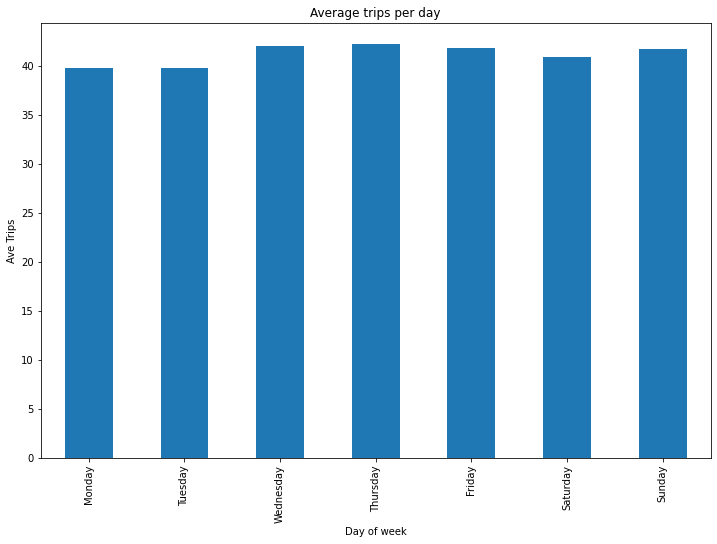

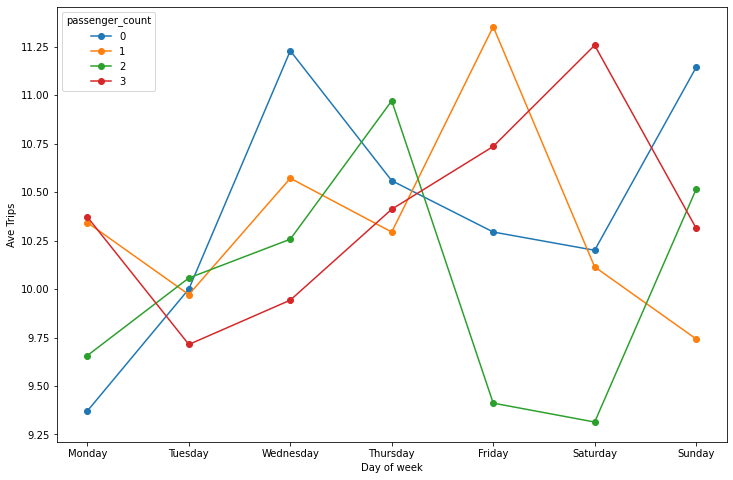

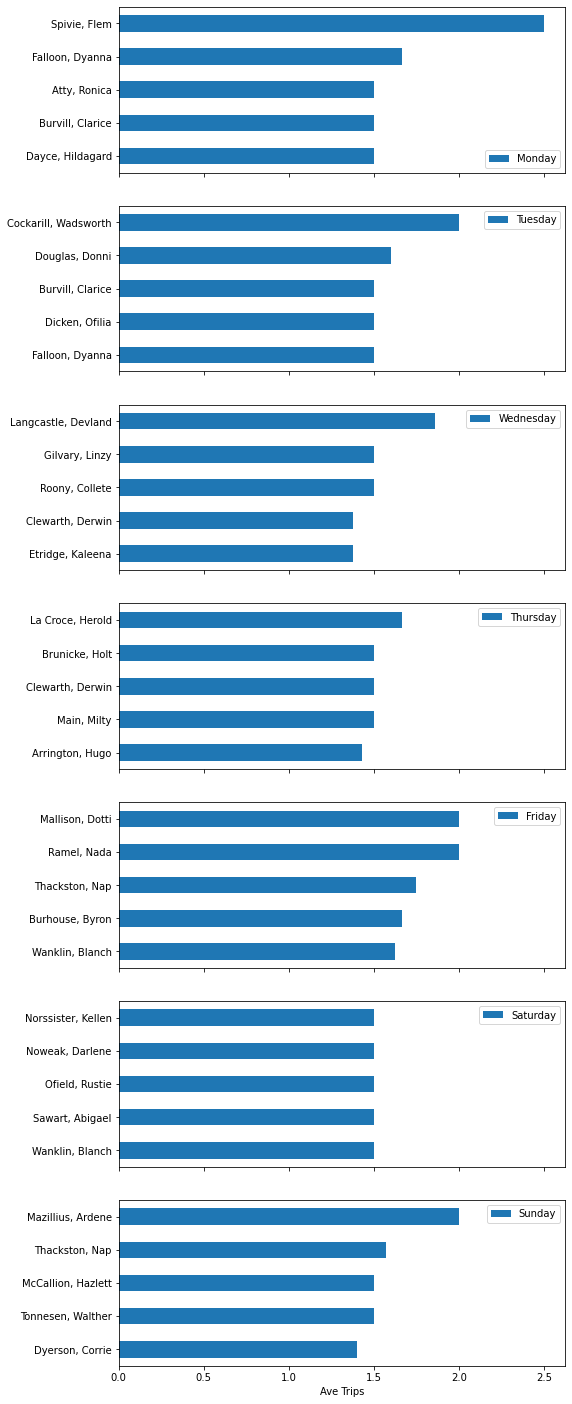

In [16]:
from matplotlib.legend import Legend
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    
    # trip tests
    ax_trip = sakay_db.plot_statistics('trip')
    ax_trip.get_figure().canvas.draw()
    
    assert_equal(ax_trip.get_title(), 'Average trips per day')
    assert_equal(
        [t.get_text() for t in ax_trip.get_xticklabels()],
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
         'Saturday', 'Sunday']
    )
    assert_equal(
        [t.get_text() for t in ax_trip.get_yticklabels()],
        ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45']
    )
    assert_equal(ax_trip.figure.get_size_inches(), (12, 8))
    assert_equal(ax_trip.get_ylabel(), 'Ave Trips')
    assert_equal(ax_trip.get_xlabel(), 'Day of week')

    
    # passenger tests
    ax_passenger = sakay_db.plot_statistics('passenger')
    ax_passenger.get_figure().canvas.draw()
    
    assert_equal(ax_passenger.get_ylabel(), 'Ave Trips')
    assert_equal(ax_passenger.get_xlabel(), 'Day of week')
    assert_equal(
        [t for t in ax_passenger.get_yticks()],
        [9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 
         11.25, 11.5]
    )
    
    assert_equal(
        ax_passenger.get_legend_handles_labels()[1],
        ['0', '1', '2', '3']
    )
    assert_equal(ax_passenger.lines[0].get_label(), '0')
    assert_equal(ax_passenger.lines[0].get_marker(), 'o')
    assert_equal(ax_passenger.lines[0].get_ls(), '-')


    # driver tests
    ax_driver = sakay_db.plot_statistics('driver')
    axes = ax_driver.get_axes()
    
    assert_equal(ax_driver.get_size_inches(), (8.0, 25.0))
    assert_equal(
        axes[0].get_position().get_points().tolist(), 
        [[0.125, 0.7879268292682927], [0.9, 0.88]]
    )
    assert_equal(axes[0].get_legend_handles_labels()[1][0], 'Monday')
    assert_equal(axes[6].get_legend_handles_labels()[1][0], 'Sunday')
    assert_equal(axes[6].get_title(), '')
    assert_equal(axes[0].get_xticks(), axes[6].get_xticks())
    

## Generate OD matrix

In [17]:
with TemporaryDirectory() as temp_dir:
    sakay_db = SakayDB(temp_dir)
    assert_equal(sakay_db.generate_odmatrix().to_numpy().tolist(), [])
    shutil.copy('trips_test2.csv', os.path.join(temp_dir, 'trips.csv'))
    shutil.copy('drivers_test2.csv',
                os.path.join(temp_dir, 'drivers.csv'))
    shutil.copy('locations.csv', os.path.join(temp_dir, 'locations.csv'))
    od_df = sakay_db.generate_odmatrix()
    assert_equal(od_df.shape, (48, 48))
    assert_equal(od_df.loc['Macpherson', 'UP Campus'], 1.25)
    assert_equal(od_df.iloc[-2, -2], 0)
    assert_equal(sakay_db
                   .generate_odmatrix(date_range=('00:00:00,1-08-2022', '23:59:59,31-08-2022'))
                   .shape, (48, 48))